In [1]:
import os
os.environ['JAX_ENABLE_X64'] = '1'

import numpy as np
import jax
import jax.numpy as jnp
from temgym_core.components import Detector, Lens
from temgym_core.gaussian import make_gaussian_image, GaussianRay, evaluate_gaussian_input_image
from temgym_core.source import ParallelBeam
from temgym_core.ray import Ray
from temgym_core.utils import fibonacci_spiral, custom_jacobian_matrix
from temgym_core.run import run_to_end

%matplotlib widget
import matplotlib.pyplot as plt

Simulation parameters

In [2]:
aperture_window_width = 1e-6  # 1 um aperture window width
num_aper_pixels = 512
aperture_pixel_size = (aperture_window_width / num_aper_pixels, aperture_window_width / num_aper_pixels)
aperture_radius = 1e-7  # 100 nm aperture radius

num_beams = int(2e4)
r1x, r1y = fibonacci_spiral(nb_samples=num_beams, radius=aperture_radius, alpha=0)

wavelength = 2e-12  # 2 pm wavelength
k = 2 * np.pi / wavelength
wo = 1e-9 # Gaussian Beam waist radius

#area of aperture
aperture_area = np.pi * aperture_radius**2
scale_factor = aperture_area / (wo ** 2 * num_beams * np.pi)

Set up rays and coordinates for gaussian beam solution

In [3]:
# Gaussian Beam Input
xs = r1x
ys = r1y
dxs = np.zeros(num_beams)
dys = np.zeros(num_beams)
zs = np.zeros(num_beams)
pathlengths = np.zeros(num_beams)
ones = np.ones(num_beams)
amplitudes = np.ones(num_beams) * scale_factor
radii_of_curv = np.full((num_beams, 2), np.inf)
theta = np.zeros(num_beams)
wavelength = wavelength
wavelengths = np.full((num_beams,), wavelength)
wo = wo
waist_xy = np.full((num_beams, 2), wo)

rays = GaussianRay(
    x=xs, 
    y=ys, 
    dx=dxs,
    dy=dys, 
    z=zs,
    pathlength=pathlengths, 
    _one=ones, 
    amplitude=amplitudes, 
    waist_xy=waist_xy,  # 1x2 per Gaussian Ray
    radii_of_curv=radii_of_curv,  # 1x2 per Gaussian Ray
    wavelength=wavelengths, 
    theta=theta,
)

input_aperture_grid = Detector(
    pixel_size=aperture_pixel_size,
    shape=(num_aper_pixels, num_aper_pixels),
    z=0.0,
)


Jit the gaussian beam summation step.

In [4]:
# Warm up JIT by evaluating a single-ray batch
rays_single = GaussianRay(
    x=xs[:1],
    y=ys[:1],
    dx=dxs[:1],
    dy=dys[:1],
    z=zs[:1],
    pathlength=pathlengths[:1],
    _one=ones[:1],
    amplitude=amplitudes[:1],
    waist_xy=waist_xy[:1],
    radii_of_curv=radii_of_curv[:1],
    wavelength=wavelengths[:1],
    theta=theta[:1],
)
_ = evaluate_gaussian_input_image(rays_single, input_aperture_grid, batch_size=1)

Evaluate the input gaussian aperture image

In [5]:
# Full evaluation
aperture_image = evaluate_gaussian_input_image(rays, input_aperture_grid, batch_size=1)

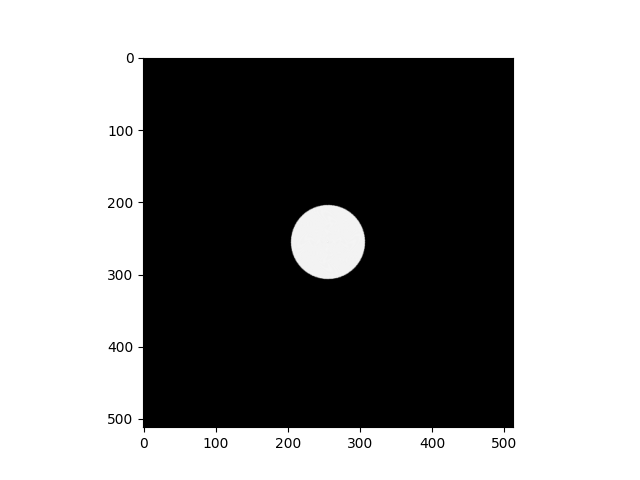

In [6]:
plt.figure()
plt.imshow(jnp.abs(aperture_image), cmap='gray')

Create the propagation parameters - A single lens with a certain focal length f. 

In [7]:
F1 = 1.0e-2
defocus = 0.0

pixel_size_bfp = wavelength * abs(F1) / (aperture_window_width)
input_beam = ParallelBeam(z=0.0, radius=aperture_radius)
Lens1 = Lens(focal_length=F1, z=abs(F1))
detector = Detector(z=abs(F1) + abs(F1), pixel_size=(pixel_size_bfp, pixel_size_bfp), shape=(num_aper_pixels, num_aper_pixels))
extent_x = detector.coords_1d[0][0], detector.coords_1d[0][-1]
extent_y = detector.coords_1d[1][0], detector.coords_1d[1][-1]

model = [
    input_beam,
    Lens1,
    detector,
]



Calculate the ABCD matrix for the system which we need to propagate Gaussians (And to rescale the Fraunhoffer FFT solution correctly!)

In [8]:
central_ray = Ray(x=0.0, y=0.0, dx=0.0, dy=0.0, z=input_beam.z, pathlength=0.0, _one=1.0)
out_ray = run_to_end(central_ray, model)

ABCD = jax.jacobian(lambda r: run_to_end(r, model))(central_ray)
ABCD = custom_jacobian_matrix(ABCD)
print('ABCD Matrix:', ABCD)
B = ABCD[0, 2]

ABCD Matrix: [[ 0.e+00  0.e+00  1.e-02  0.e+00  0.e+00]
 [ 0.e+00  0.e+00  0.e+00  1.e-02  0.e+00]
 [-1.e+02  0.e+00  0.e+00  0.e+00  0.e+00]
 [ 0.e+00 -1.e+02  0.e+00  0.e+00  0.e+00]
 [ 0.e+00  0.e+00  0.e+00  0.e+00  1.e+00]]


Perform Gaussian Beam summation

In [9]:
rays = GaussianRay(
    x=xs, 
    y=ys, 
    dx=dxs,
    dy=dys, 
    z=jnp.ones_like(xs) * input_beam.z,
    pathlength=pathlengths, 
    _one=ones, 
    amplitude=amplitudes, 
    waist_xy=waist_xy,
    radii_of_curv=radii_of_curv,
    wavelength=wavelengths, 
    theta=theta,
)
gaussian_image = make_gaussian_image(rays, model, batch_size=10)
gaussian_image = jnp.abs(gaussian_image)

Central ray coordinates

In [10]:
central_rays = rays.to_ray()
out_rays = run_to_end(central_rays, model)

Fraunhoffer (Collins Integral with A = 0, B = f, C = -1/f, D = 0) Solution

In [11]:
du, dv = aperture_pixel_size
diffraction_of_aperture = jnp.fft.ifftshift(jnp.fft.fft2(aperture_image)) * (du * dv) / (1j * wavelength * B) # Very important energy conservation factor
det_image_in_focus = jnp.abs(diffraction_of_aperture)

diff = jnp.abs(det_image_in_focus - gaussian_image)

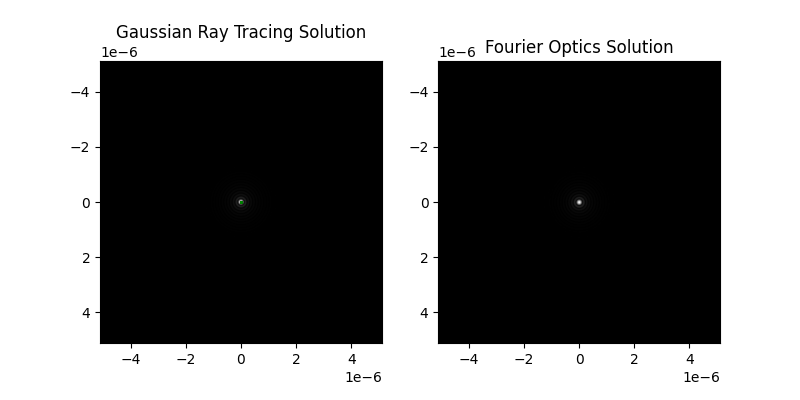

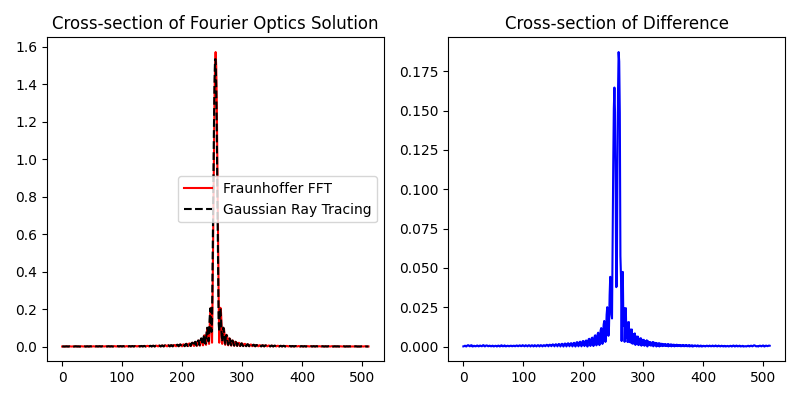

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[0].plot(out_rays.x, out_rays.y, 'g.', markersize=1, alpha=0.1)
ax[0].imshow(gaussian_image, cmap="gray", extent=[extent_x[0], extent_x[1], extent_y[0], extent_y[1]])
ax[0].set_title('Gaussian Ray Tracing Solution')
ax[1].imshow(det_image_in_focus, cmap="gray", extent=[extent_x[0], extent_x[1], extent_y[0], extent_y[1]])
ax[1].set_title('Fourier Optics Solution')

fig_cs, ax_cs = plt.subplots(1, 2, figsize=(8, 4))
ax_cs[0].plot(det_image_in_focus[detector.shape[0]//2, :], color='r', label='Fraunhoffer FFT')
ax_cs[0].plot(gaussian_image[detector.shape[0]//2, :], color='k', linestyle='dashed', label='Gaussian Ray Tracing')
ax_cs[0].set_title('Cross-section of Fourier Optics Solution')
ax_cs[1].set_title('Cross-section of Difference')
ax_cs[1].plot(diff[detector.shape[0]//2, :], color='b')
ax_cs[0].legend()
plt.tight_layout()